## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Make Model Class

In [2]:
# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    # Input Layer (7 features of the apple) -->
    # Hidden Layer 1 (number of neurons) -->
    # Hidden Layer 2 (number of neurons) -->
    # Output ('good' or 'bad')
    def __init__(self, input_features=7, h1=14, h2=14, output_features=2):
        super().__init__() # instantiate our nn.Module
        self.fc1 = nn.Linear(input_features, h1) # fc, fully connected (layer)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output_features)

    # Define forward function, computes the forward pass of the NN
    def forward(self, x):
        x = F.relu(self.fc1(x)) # relu(), if output is less than 0, make it 0
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

# Import Data and Prepare for Use

In [3]:
# import the data
appledata = pd.read_csv('apple_quality.csv')

# delete A_id column
appledata_clean = appledata.drop('A_id', axis=1)

# get rid of any rows containing NA values
appledata_clean = appledata_clean.dropna()

# all 'good' Quality is 1 and all 'bad' is 0
appledata_clean['Quality'] = appledata_clean['Quality'].replace({'good': 1, 'bad': 0})

# change Acidity to be a float
appledata_clean['Acidity'] = appledata_clean['Acidity'].astype(float)

# display first rows of csv
appledata_clean.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


# Pairplot to Showcase Data

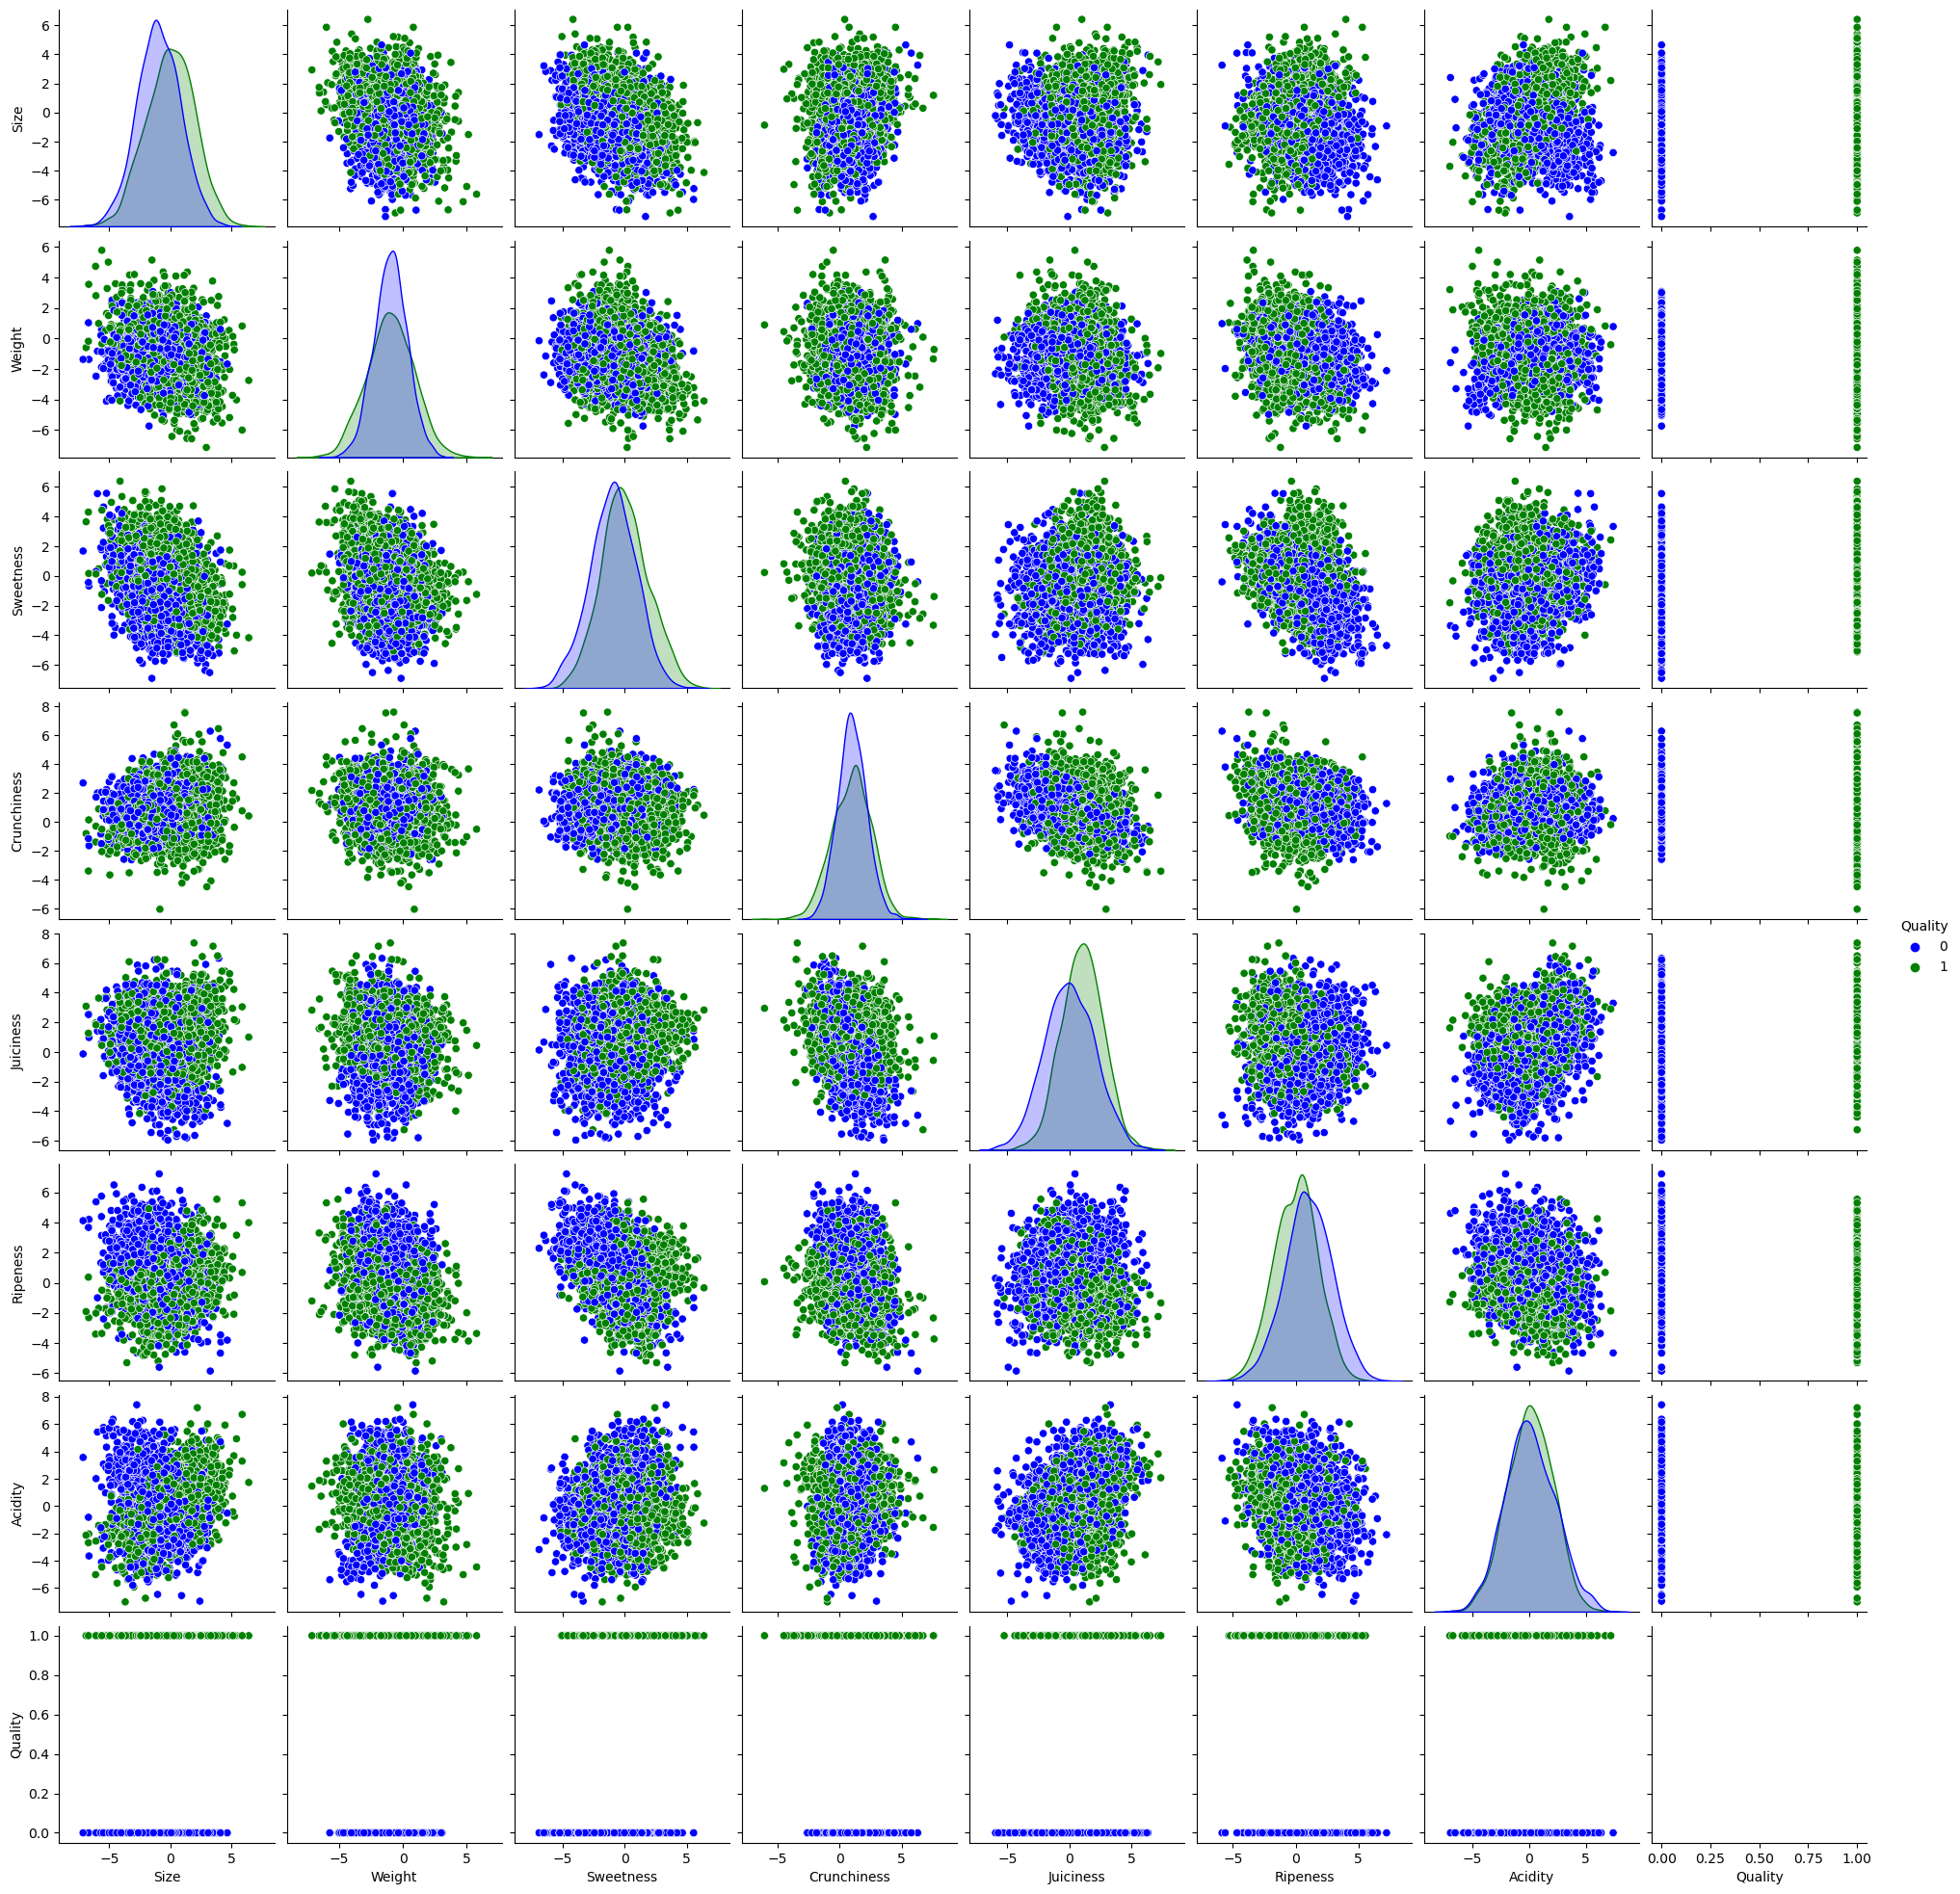

In [4]:
# Suppress FutureWarnings related to use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)

# Scatterplot matrix for selected predictors with hue='Quality'
selected_predictors = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Quality']
# 1 = good (green), 0 = bad (blue)
pairplot = sns.pairplot(appledata_clean, vars=selected_predictors, hue='Quality', palette={1: 'green', 0: 'blue'})

plt.show()

# Get Training Data Ready for Split

In [5]:
# Set X,y for Train Test Split
X = appledata_clean.drop('Quality', axis=1) # Just the 7 features
y = appledata_clean['Quality'] # Target variable, Quality

# Convert these to numpy arrays
X = X.values
y = y.values

# Train the Model

In [6]:
# Train our model!

# Splits data, trains model, returns results
def train_and_evaluate_model(X, y, train_size, val_size, test_size, epochs, num_repeats, learning_rate):
    # Initialize lists and variables
    test_accuracies = []
    losses = []
    val_losses = []
    all_train_losses = []
    all_val_losses = []
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    
    for repeat in range(num_repeats):
        # Lists to store losses for this repeat
        repeat_train_losses = []
        repeat_val_losses = []
        
        # Initialize a new model instance
        model = Model()
    
        # Train Test Split
        # First, split into train + temp (test + val) sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_size))
        # Now, split the temp into actual test and val sets
        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + val_size))
    
        # Convert X features to float tensors
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        X_val = torch.FloatTensor(X_val)                          
    
        # Convert y labels to tensors long
        y_train = torch.LongTensor(y_train)
        y_test = torch.LongTensor(y_test)
        y_val = torch.LongTensor(y_val)
    
        # Set the criterion of model to measure the error, how far off the predictions are the data
        criterion = nn.CrossEntropyLoss()
        # Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # lower the learning rate, the longer it takes to train the model
    
        # Training loop
        for i in range(epochs): # Epochs? (one run through all the training data in our network)
            # Go forward and get a prediction
            y_pred = model.forward(X_train) # Get predicted results
    
            # Measure the loss/error, gonna be high at first
            loss = criterion(y_pred, y_train) # predicted values vs the y_train
    
            # Do some back propagation: take the error rate of forward propagation and feed it back
                # through the network to fine tune the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Validation phase
            with torch.no_grad():  # Basically turn off back propagation
                y_val_pred = model.forward(X_val)  # Predict on validation set
                val_loss = criterion(y_val_pred, y_val)  # Calculate validation loss
    
            repeat_train_losses.append(loss.item())
            repeat_val_losses.append(val_loss.item())
    
            # print every 10 epoch
            # if i % 10 == 0:
                # print(f'Epoch: {i}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
    
        # Append the losses of this repeat to the all_*_losses lists
        all_train_losses.append(repeat_train_losses)
        all_val_losses.append(repeat_val_losses)
    
        # After training, evaluate the model's performance on the test set
        with torch.no_grad():
            y_test_pred = model(X_test)
            # Assuming your model outputs logits, apply softmax to get probabilities
            y_test_pred_probs = F.softmax(y_test_pred, dim=1)
            # Pick the class with the highest probability as the prediction
            y_test_pred_labels = torch.argmax(y_test_pred_probs, dim=1)
            # Calculate accuracy
            accuracy = (y_test_pred_labels == y_test).float().mean().item()
            # Append the accuracy to our list
            test_accuracies.append(accuracy)

        # Convert tensors to numpy arrays for sklearn metrics
        y_test_pred_labels_np = y_test_pred_labels.numpy()
        y_test_np = y_test.numpy()

        # Calculate metrics
        acc = accuracy_score(y_test_np, y_test_pred_labels_np)
        prec = precision_score(y_test_np, y_test_pred_labels_np)
        rec = recall_score(y_test_np, y_test_pred_labels_np)
        f1 = f1_score(y_test_np, y_test_pred_labels_np)

        # Append metrics to their respective lists
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    
    # Now calculate the average loss per epoch across all repeats
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)
    
    # Calculate the average and variance of the test accuracies
    average_accuracy = np.mean(test_accuracies)
    variance_accuracy = np.var(test_accuracies)


    # Results
    plt.figure(figsize=(10, 6))
    # Using a scatter plot to show individual test accuracies for each repeat
    plt.scatter(range(1, num_repeats + 1), test_accuracies, color='blue', label='Test Accuracies')
    
    # Connecting the dots with a line plot for better visualization of trends
    plt.plot(range(1, num_repeats + 1), test_accuracies, color='lightblue', label='Trendline')
    
    plt.title('Test Accuracies Over Repeats')
    plt.xlabel('Repeat')
    plt.ylabel('Test Accuracy')
    plt.xticks(range(1, num_repeats + 1))  # Ensure ticks for each repeat
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Average Test Accuracy: {average_accuracy}")
    print(f"Variance of Test Accuracy: {variance_accuracy}")

    # Graph it out!
    # Plotting the average losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), avg_train_losses, label='Average Training Loss')
    plt.plot(range(epochs), avg_val_losses, label='Average Validation Loss')
    plt.ylabel("Loss")
    plt.xlabel('Epoch')
    plt.title('Average Training and Validation Loss')
    plt.legend()
    plt.show()

    # After all repeats, calculate and print average and variance for each metric
    print("Average and Variance of Metrics Over All Repeats:")
    print(f"Accuracy:  Avg = {np.mean(accuracies):.4f}, Var = {np.var(accuracies):.4f}")
    print(f"Precision: Avg = {np.mean(precisions):.4f}, Var = {np.var(precisions):.4f}")
    print(f"Recall:    Avg = {np.mean(recalls):.4f}, Var = {np.var(recalls):.4f}")
    print(f"F1 Score:  Avg = {np.mean(f1_scores):.4f}, Var = {np.var(f1_scores):.4f}")

# Results
### If the validation loss starts increasing while the training loss keeps decreasing, it's a sign of overfitting, indicating that the model is memorizing the training data rather than learning general patterns.

In [7]:
# Define variables for func.
learning_rate = 0.01 # lower the learning rate, the longer it takes to train the model
epochs = 200
num_repeats = 50

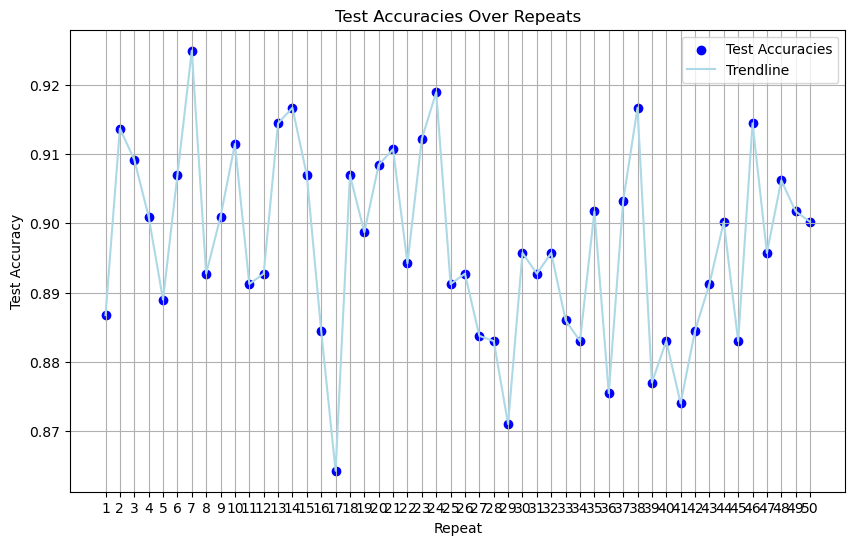

Average Test Accuracy: 0.8968192064762115
Variance of Test Accuracy: 0.00018540745751156038


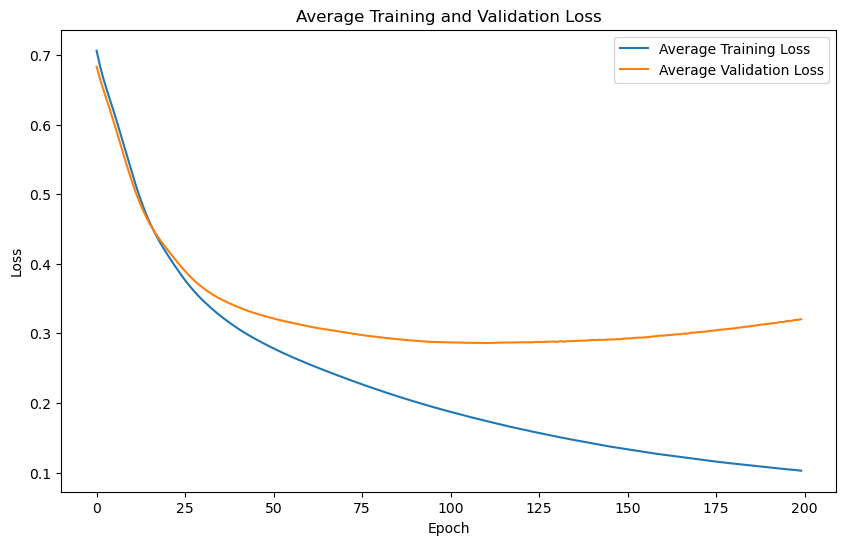

Average and Variance of Metrics Over All Repeats:
Accuracy:  Avg = 0.8968, Var = 0.0002
Precision: Avg = 0.8965, Var = 0.0003
Recall:    Avg = 0.8980, Var = 0.0004
F1 Score:  Avg = 0.8971, Var = 0.0002


In [8]:
# train_and_evaluate_model(X, y, train_size, val_size, test_size, epochs, num_repeats, learning_rate)
train_and_evaluate_model(X, y, 1/3, 1/3, 1/3, epochs, num_repeats, learning_rate)

### The split below should give the best results since a big training set is the best

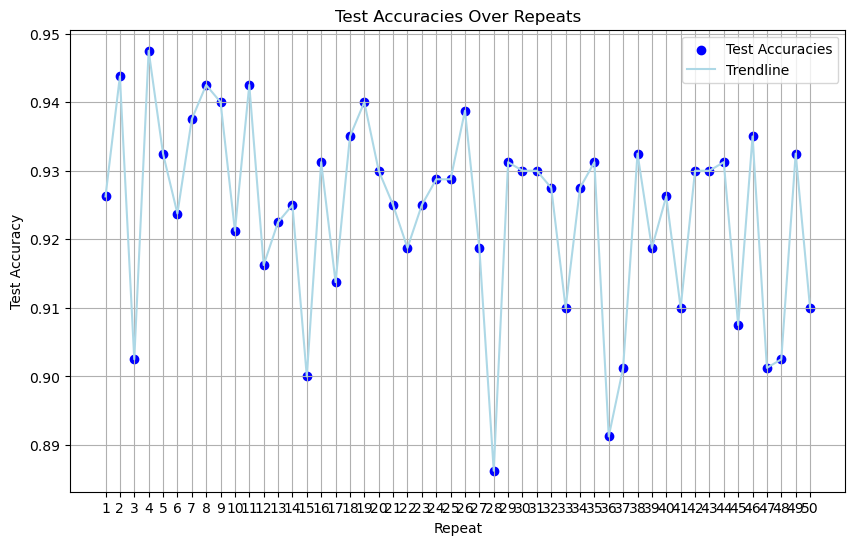

Average Test Accuracy: 0.923824999332428
Variance of Test Accuracy: 0.0001924005849268667


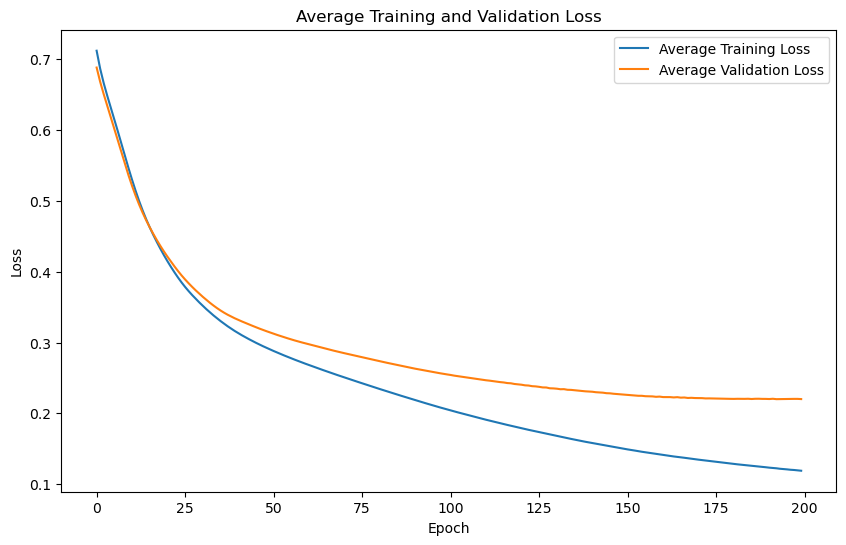

Average and Variance of Metrics Over All Repeats:
Accuracy:  Avg = 0.9238, Var = 0.0002
Precision: Avg = 0.9216, Var = 0.0002
Recall:    Avg = 0.9274, Var = 0.0004
F1 Score:  Avg = 0.9244, Var = 0.0002


In [9]:
# train_and_evaluate_model(X, y, train_size, val_size, test_size, epochs, num_repeats, learning_rate)
train_and_evaluate_model(X, y, 6/10, 2/10, 2/10, epochs, num_repeats, learning_rate)

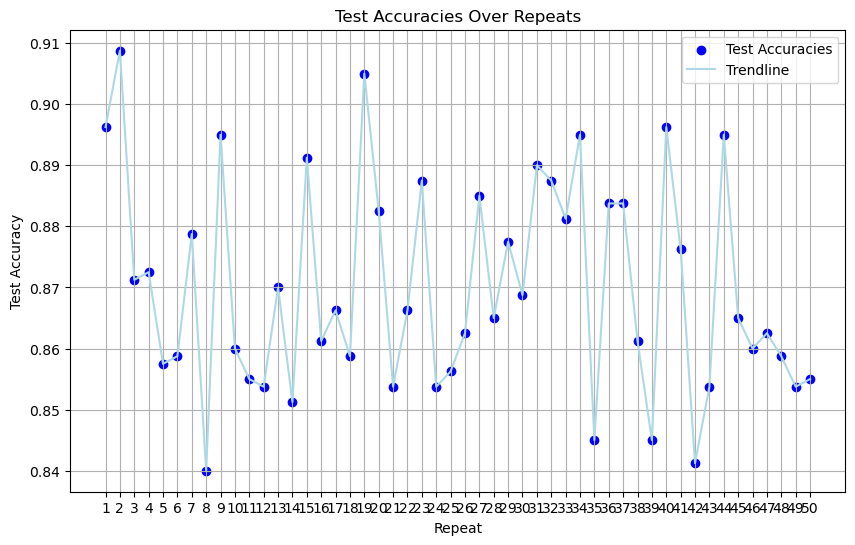

Average Test Accuracy: 0.8699999988079071
Variance of Test Accuracy: 0.0002975624420645673


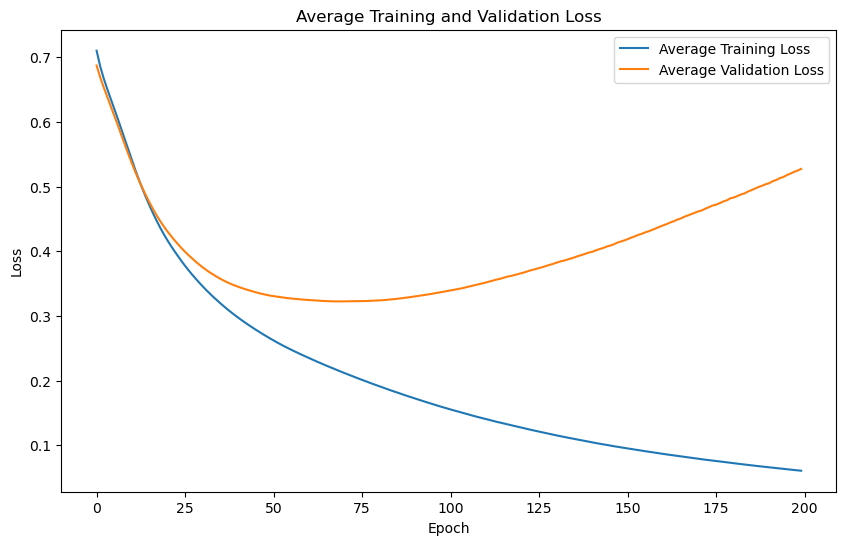

Average and Variance of Metrics Over All Repeats:
Accuracy:  Avg = 0.8700, Var = 0.0003
Precision: Avg = 0.8696, Var = 0.0003
Recall:    Avg = 0.8737, Var = 0.0009
F1 Score:  Avg = 0.8713, Var = 0.0003


In [10]:
# train_and_evaluate_model(X, y, train_size, val_size, test_size, epochs, num_repeats, learning_rate)
train_and_evaluate_model(X, y, 2/10, 2/10, 6/10, epochs, num_repeats, learning_rate)

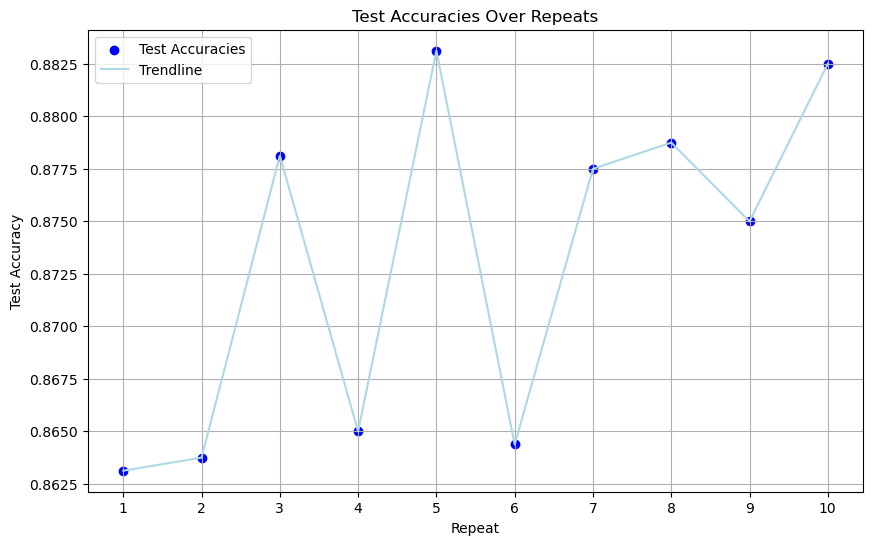

Average Test Accuracy: 0.8731250047683716
Variance of Test Accuracy: 5.97656413914649e-05


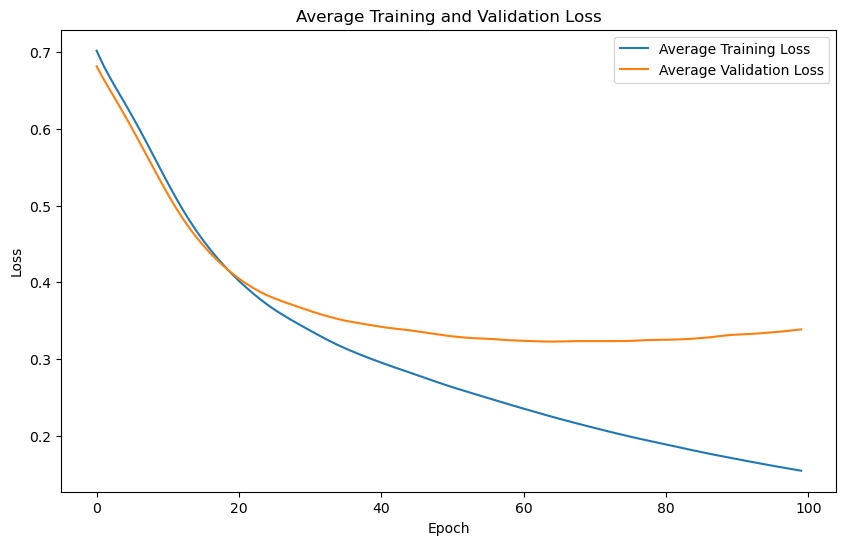

Average and Variance of Metrics Over All Repeats:
Accuracy:  Avg = 0.8731, Var = 0.0001
Precision: Avg = 0.8671, Var = 0.0002
Recall:    Avg = 0.8831, Var = 0.0002
F1 Score:  Avg = 0.8749, Var = 0.0001


In [11]:
# train_and_evaluate_model(X, y, train_size, val_size, test_size, epochs, num_repeats)
train_and_evaluate_model(X, y, 2/10, 2/10, 2/10, 100, 10, 0.01)